In [60]:
import matplotlib.pyplot as plt
import os
import re
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

###stackoverflow dataset is here for us to use containing the body of several thousand programming questions (for example, "How can sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). our task is to take a question as input, and predict the appropriate tag, in this case, Python.
###to increase the difficulty of the classification problem, occurrences of the words Python, CSharp, JavaScript, or Java in the programming questions have been replaced with the word blank (as many questions contain the language they're about).

####download data in tar format

In [61]:
url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')


####show the content of the folder

In [3]:
os.listdir('/content')

['.config',
 'train',
 'stack_overflow.tar.gz',
 'test',
 'README.md',
 'sample_data']

####make directory for training set

In [4]:
train_dir = os.path.join('/content','train')

####content of training directory

In [5]:
os.listdir(train_dir)

['csharp', 'python', 'javascript', 'java']

####see an example of one question in stackoverflow

In [6]:
sample_file = os.path.join(train_dir, 'javascript/1138.txt')
with open(sample_file) as f:
  print(f.read())

"changing image with blank i'm using jquery mobile to make an app. i'm playing a sound file when the page loads and displaying an image to turn the sound file off when clicked. everything is working fine however i can only get the image to change on the index page. i can turn off the sound file on any page however the image wont change on any other page. please help =) &lt;3 ..&lt;script type=""text/blank""&gt;.var newsrc = ""soundoff.png"";..function changeimage() {.    var sample = document.getelementbyid(""foobar"");.    sample.pause();..    if ( newsrc == ""soundoff.png"" ) {.        document.images[""sound""].src = ""/img/soundoff.png"";.        document.images[""sound""].alt = ""sound off"";.        newsrc  = ""soundon.png"";.    }.    else {.        var sample = document.getelementbyid(""foobar"");.        sample.play();.        document.images[""sound""].src = ""/img/soundon.png"";.        document.images[""sound""].alt = ""sound on"";.        newsrc  = ""soundoff.png"";.    }.

###make dataset for training data
####we will use the text_dataset_from_directory utility to create a labeled tf.data.Dataset

In [7]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


####corresponding label for each language

In [9]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


####make dataset for val and test data

In [10]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [11]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'test', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


####there are 8000 examples in the training folder, of which you will use 80% (or 6400) for training.

##Prepare the dataset for training
####we will standardize, tokenize, and vectorize the data using the helpful preprocessing.TextVectorization layer.
####the reviews contain various HTML tags like <br />. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). we will write a custom standardization function to remove the HTML.

In [12]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation),'')

####Next, we will create a TextVectorization layer. we will use this layer to standardize, tokenize, and vectorize our data. we set the output_mode to int to create unique integer indices for each token.

In [13]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

####Next, we will call adapt to fit the state of the preprocessing layer to the dataset.

In [14]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

####make a function for processing data

In [15]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

####As a final preprocessing step, we will apply the TextVectorization layer we created earlier to the train, validation, and test dataset.

In [16]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

####example of the word of integer 2000

In [17]:
print("2000 ---> ",vectorize_layer.get_vocabulary()[2000])

2000 --->  intended


###create model

In [137]:
embedding_dim = 8

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.5),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.5),
  # layers.Dense(16,activation='relu'),
  # layers.Dropout(0.4),
  # layers.Dense(16,activation='relu'),
  # layers.Dropout(0.4),
  layers.Dense(4)])

model.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 8)           80008     
_________________________________________________________________
dropout_22 (Dropout)         (None, None, 8)           0         
_________________________________________________________________
global_average_pooling1d_8 ( (None, 8)                 0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 36        
Total params: 80,044
Trainable params: 80,044
Non-trainable params: 0
_________________________________________________________________


###Loss function and optimizer

In [138]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True
)

####fit the model

In [139]:
epochs = 150
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks = [early_stopping],
    epochs=epochs)

Epoch 1/150
200/200 [==============================] - 4s 16ms/step - loss: 1.3847 - accuracy: 0.2859 - val_loss: 1.3817 - val_accuracy: 0.2906
Epoch 2/150
200/200 [==============================] - 3s 16ms/step - loss: 1.3763 - accuracy: 0.3759 - val_loss: 1.3700 - val_accuracy: 0.4181
Epoch 3/150
200/200 [==============================] - 3s 17ms/step - loss: 1.3586 - accuracy: 0.4320 - val_loss: 1.3482 - val_accuracy: 0.5400
Epoch 4/150
200/200 [==============================] - 3s 16ms/step - loss: 1.3325 - accuracy: 0.4611 - val_loss: 1.3185 - val_accuracy: 0.5706
Epoch 5/150
200/200 [==============================] - 3s 15ms/step - loss: 1.3024 - accuracy: 0.5077 - val_loss: 1.2835 - val_accuracy: 0.6031
Epoch 6/150
200/200 [==============================] - 3s 15ms/step - loss: 1.2615 - accuracy: 0.5514 - val_loss: 1.2423 - val_accuracy: 0.6156
Epoch 7/150
200/200 [==============================] - 3s 16ms/step - loss: 1.2230 - accuracy: 0.5769 - val_loss: 1.2013 - val_accuracy:

####accuracy and loss plot of the model

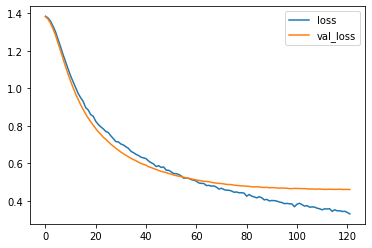

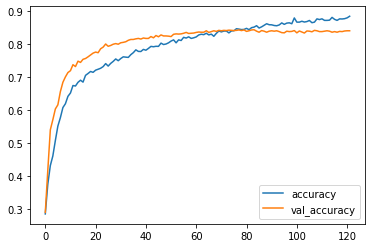

In [140]:
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

####evaluate our model on the test set

In [141]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 3s 11ms/step - loss: 0.5107 - accuracy: 0.8170
Loss:  0.510725200176239
Accuracy:  0.8169999718666077


###export the model

In [142]:
prob_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Softmax()
])

###prediction on test dataset

In [143]:
prediction = prob_model.predict(raw_test_ds)

In [144]:
import numpy as np
np.argmax(prediction[0])

3

####prediction base on the hieghst probability

In [145]:
np.argmax(prediction,axis=1)

array([3, 1, 1, ..., 2, 2, 0])

####example of this prediction(the language is python)

In [148]:
example = [
  'i have trouble with this code: def(a,b): return a+b    print("hello world")   if(a==b): print("yeey")'
]

prob_model.predict(example)

array([[0.17116053, 0.21818301, 0.2263149 , 0.3843416 ]], dtype=float32)

In [149]:
raw_train_ds.class_names[3]

'python'

##we can see the hieghst probability is at index 3 which is python